# Linear regression with `numpy` and  `pytorch`

## Introduction

Linear regression, as abundantly seen in the Lectures, is a fundamental machine learning  approach. In this tutorial example, we will progressively solve a simple linear regression (SLR) problem with increasignly sophisticated and efficient tools.

1. Use classical `numpy` and manually code the SLR with gradient descent.
2. Compare this manual solution with that obtained from the `LinearRegression` function of `sklearn`.
3. Use `pytorch` to manually code the SLR with gradient descent.
4. Visualize the computational graph used by `pytorch` to compute the gradient by backpropagagtion.
5. Use `pytorch` with a built-in optimizer.
6. Using the `Linear` model of `pytorch`, perform rigorous ML with cross-validation (train-test).


## Formulation

We want to find the linear regression curve
$$ y = a + bx + \eta, $$
where $\eta$ is centered Gaussian noise.

We start by generating noisy data with $$a = 1, \quad b=2$$ and $$\eta \sim \mathcal{N} (0,0.1).$$

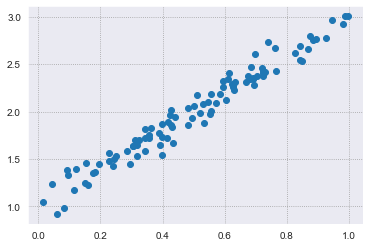

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set() # for default style
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
# generate the data
np.random.seed(123)
x = np.random.rand(100,1)
y = 1 + 2*x + 0.1*np.random.randn(100,1)

#plt.scatter(x,y)
plt.plot(x,y,"o")
plt.show()

For machine learning, we split the data into training and validation sets.

Text(0.5, 0, 'x')

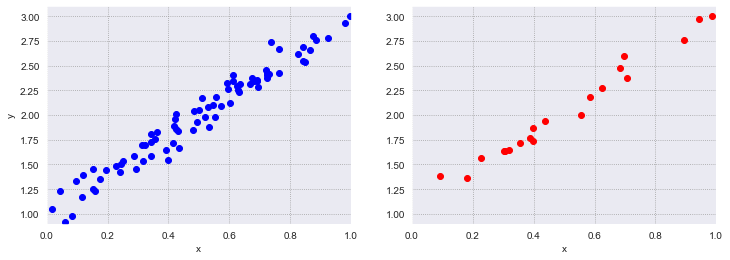

In [2]:
# get training and validation sets
idx = np.arange(100)
np.random.shuffle(idx)

train_idx = idx[:80]
test_idx  = idx[80:]

x_train, y_train = x[train_idx], y[train_idx]
x_test, y_test = x[test_idx], y[test_idx]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x_train, y_train, "bo")
plt.xlim([0, 1])
plt.ylim([0.9, 3.1])
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(122)
plt.plot(x_test, y_test, "ro")
plt.xlim([0, 1])
plt.ylim([0.9, 3.1])
plt.xlabel('x')

## 1. Linear regression with `numpy`

For linear regression, we can calculate explicit formulas for the gradients of the parameters, $a$ and $b.$ 
Let us define the model error
$$ e_i = y_i - \hat{y}_i ,$$
where
$$ \hat{y}_i = \hat{a} - \hat{b} x_i . $$

We can then define the least squares objective/loss function, 
$$ F = \frac{1}{n} \sum_{i=1}^{n} e_i^2. $$

Expanding, differentiating and setting the gradient equal to zero, we readily compute the terms of the gradient and even the optimal values,
$$ \nabla F_a = -2 \frac{1}{n} \sum_{i=1}^{n} e_i$$
and
$$ \nabla F_b = -2 \frac{1}{n} \sum_{i=1}^{n} x_i e_i,$$
respectively. 

In [3]:
# linear regression with numpy
# 1. initialize
np.random.seed(123)
a = np.random.randn(1)
b = np.random.randn(1)

print('Initial values ', a, b)

# 2. set hyperparameter (learning rate)
lr = 1e-1
# define number of iterations (epochs)
n_iter = 1000

# optimization loop
for iter in range(n_iter):
    # predicted output
    yhat = a + b*x_train
    # compute error and loss
    err = y_train - yhat
    # MSE
    loss = (err**2).mean()
    # compute analytical gradients for a and b
    a_grad = -2*err.mean()
    b_grad = -2*(x_train*err).mean()
    # steepest descent update
    a = a - lr*a_grad
    b = b - lr*b_grad

print('Final values   ', a, b)
print('Absolute errors', np.abs(a-1), np.abs(b-2))

Initial values  [-1.0856306] [0.99734545]
Final values    [1.00787626] [1.97428005]
Absolute errors [0.00787626] [0.02571995]


## 2. Compare with `sklearn`

In [4]:
# Sanity Check: do we get the same results from sklearn as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print('sklearn results',linr.intercept_, linr.coef_[0])

sklearn results [1.00788001] [1.97427291]


## 3. Implementation in `pytorch`

Import the necessary librairies, check whether a GPU is available, and perform the regression.

In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

#device = 'cuda' if torch_cuda_is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
#device = 'cpu'

# convert nunmpy arrays into torch tensors
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.mps.FloatTensor


In [7]:
# initialize parameters and set grad = true
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)
# could send them to the gpu with .to(device)...

tensor([-0.6051], device='mps:0', requires_grad=True) tensor([1.3795], device='mps:0', requires_grad=True)


Now we apply the automatic differentitation, aka autograd. We will use the methods

   - `backward()` to compute the gradient of the loss function wrt the parameters
   - `zero_()` to prevent (default) accumulation of the computed gradients

In [8]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(123)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# optimization loop:
for epoch in range(n_epochs):
    yhat  = a + b*x_train_tensor
    error = y_train_tensor - yhat
    loss  = (error**2).mean()
    # compute gradients wrt a and b
    loss.backward()
    # check gradients
    #print('a and b gradients', a.grad, b.grad)
    # gradient descent update 
    with torch.no_grad():
        a -= lr*a.grad
        b -= lr*b.grad
    # zero the gradients for next iteration
    a.grad.zero_()
    b.grad.zero_()
    
print('Final values   ', a, b)
print('Absolute errors', torch.abs(a-1), torch.abs(b-2)) 

Final values    tensor([1.0079], device='mps:0', requires_grad=True) tensor([1.9743], device='mps:0', requires_grad=True)
Absolute errors tensor([0.0079], device='mps:0', grad_fn=<AbsBackward0>) tensor([0.0257], device='mps:0', grad_fn=<AbsBackward0>)


## 4. Visualize the computational graph using `torchviz`.

Note that this is the graph used by the automatic differentiation (autograd) to compute the gradient of the loss function with respect to each declared parameter. It is just an automatized implementation of the chain rule---see (https://cs231n.github.io/). The major advantage lies in the fact that, being completely general, it can be applied to *any* loss function and to *any* number of parameters. 

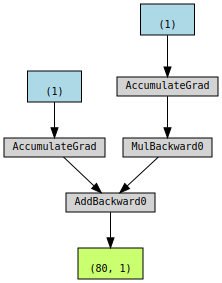

In [9]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

make_dot(yhat)

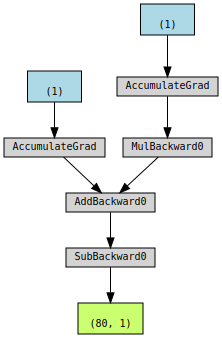

In [10]:
make_dot(error)

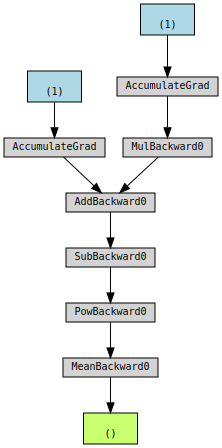

In [11]:
make_dot(loss)

## 5. Use  PyTorch optimizers.

To go even further with PyTorch, let us use one of the built-in optimizers instead of manually coding the update in the optimization loop.

For this, we must

   - define the optimizer and its hyperparameters
   - use the `step()` method



In [12]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print('Initial values: ',a, b)

lr = 1e-1
n_epochs = 1000

# define an SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # no longer need the manual update
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # no longer need the to tell PyTorch to let gradients go
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print('Optimal values: ',a, b)

Initial values:  tensor([-1.2425], device='mps:0', requires_grad=True) tensor([0.4424], device='mps:0', requires_grad=True)
Optimal values:  tensor([1.0079], device='mps:0', requires_grad=True) tensor([1.9743], device='mps:0', requires_grad=True)


Different loss functions are provided and can be specified before the loop.

In [13]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# define MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # no longer need to compute manual loss
    # error = y_train_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.5485], device='mps:0', requires_grad=True) tensor([-0.7694], device='mps:0', requires_grad=True)
tensor([1.0080], device='mps:0', requires_grad=True) tensor([1.9741], device='mps:0', requires_grad=True)


## 6. Models for training + validation/evaluation

We have performed the training. However, to actually use the trained model for evaluation and validation, then predictions, we should use a python class that inherits from the `module` class. This class needs to implement two basic methods:

   - `__init__(self)` that defines the parts of the model, in our case a and b
   - `forward(self,x)` that performs the actual computation and outputs a prediction, given the input x


In [14]:
class LinReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # compute the outputs/predictions
        return self.a + self.b*x

A `class` provides methods:

  - `parameters()` for retrieving an iterator over all its parameters
  - `state_dict()` to get current values of all parameters


In [15]:
torch.manual_seed(42)

# create a model and send it to the device
model = LinReg().to(device)
# inspect its parameters using state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # set model to training mode...
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367], device='mps:0')), ('b', tensor([0.1288], device='mps:0'))])
OrderedDict([('a', tensor([1.0079], device='mps:0')), ('b', tensor([1.9742], device='mps:0'))])


Instead of manually creating the two parameters of the linear regression model, we can use pytorch's `Linear` model by forming a nested model.

In [16]:
class LayerLinReg(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of custom parameters, use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)



The 3 elements of a training step are:

  1.  the optimizer
  2.  the loss function
  3.  the model

We can combine the three into a single function to perform a training step.


In [17]:
def make_train_step(model, loss_fn, optimizer):
    # build function that performs a step in the train loop
    def train_step(x, y):
        # set model to TRAIN mode
        model.train()
        # make predictions
        yhat = model(x)
        # compute loss
        loss = loss_fn(y, yhat)
        # compute gradients
        loss.backward()
        # update parameters and zero the gradients
        optimizer.step()
        optimizer.zero_grad()
        # return the loss
        return loss.item()
    
    # return the function that will be called inside the train loop
    return train_step

Now, do the training

In [20]:
model      = LayerLinReg().to(device) # model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn    = nn.MSELoss(reduction='mean')
optimizer  = optim.SGD(model.parameters(), lr=1e-1)
train_step = make_train_step(model, loss_fn, optimizer)

losses = []
# loop
for epoch in range(n_epochs):
    # performs one train step and return the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# checks model's parameters
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[1.9741]], device='mps:0')), ('linear.bias', tensor([1.0079], device='mps:0'))])


Validation is next. This step will not be repeated here...

For more details, on can consult more advanced treatments of Deep Learning with Pytorch, such as the book of [D.V Godoy](https://pytorchstepbystep.com/)